In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.linalg as linalg

$$
\pi^* = \argmin_{\pi \in \Pi(\mu, \nu)}\left[\int \frac{c(x,y)}{2\epsilon^2} d\pi + D(\pi||\mu\otimes\nu)\right]
$$

In [3]:
def normalize(x):
    return x/np.sum(x)

def relative_entropy(p, q):
    return np.sum(p * np.log(np.divide(p, q)))

def c(x, y, eps):
    return (x - y)**2 / (2 * eps**2)

def OT_sinkhorn(mu, nu, K, maxiters = 1000, stop_threshold = 1e-9, tol=1e-4):
    u = np.ones_like(mu)
    v = np.ones_like(nu)

    for i in range(maxiters):
        u_prev = u
        
        u = mu / (K @ v)
        v = nu / (K.T @ u)
    
        coupling = np.diag(u) @ K @ np.diag(v) # returns coupling
        err = np.linalg.norm(coupling.sum(axis=1) - mu)
        
        if err < stop_threshold or np.linalg.norm(u - u_prev)/np.linalg.norm(u_prev) < tol:
            break
    return coupling


In [4]:
# def R(t):
#     return np.array([[np.cos(t), -np.sin(t)], 
#                      [np.sin(t), np.cos(t)]])


Transport map $\pi$ from $\mu$ to $\nu$ in discrete form is given by, $\sum_j \pi_{ij} = \nu_i$, $\sum_i \pi_{ij} = \mu_j$. Independent coupling gives $\pi_{ij} = \nu_i \mu_j$ or $\pi = \nu \mu^T$.

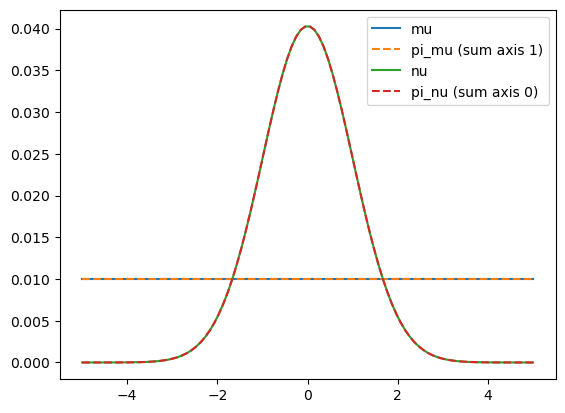

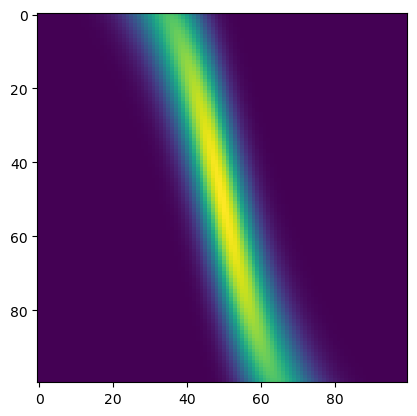

In [5]:
k = 100
n = 1000
eps = 1
x = np.linspace(-5, 5, k)
X, Y = np.meshgrid(x, x)
mu = np.ones(k)
mu = normalize(mu)
nu = stats.norm.pdf(x, 0, 1)
nu = normalize(nu)

mu_nu_ind = np.outer(mu, nu)

K = np.exp(-np.abs(X - Y)**2/2*eps**2)
pi = OT_sinkhorn(mu, nu, K)
plt.plot(x, mu, label="mu")
plt.plot(x, np.sum(pi, axis=1), "--", label="pi_mu (sum axis 1)")
plt.plot(x, nu, label="nu")
plt.plot(x, np.sum(pi, axis=0), "--", label="pi_nu (sum axis 0)")
plt.legend()
plt.show()
# pi = OT_sinkhorn(nu, mu, K)
plt.imshow(pi)

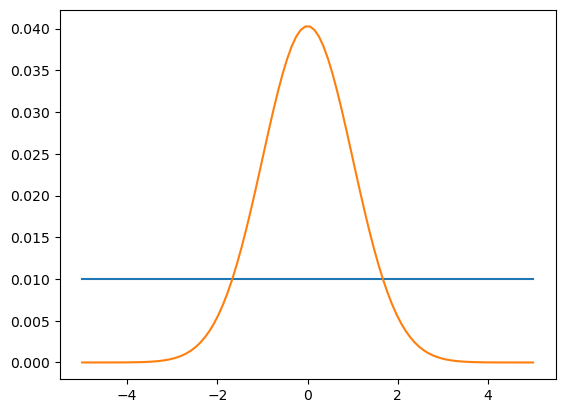

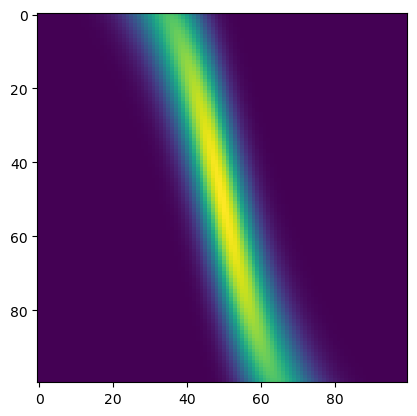

In [6]:
k = 100
n = 1000
eps = 1
x = np.linspace(-5, 5, k)
X, Y = np.meshgrid(x, x)
mu = np.ones(k)
mu = normalize(mu)
nu = stats.norm.pdf(x, 0, 1)
nu = normalize(nu)
plt.plot(x, mu)
plt.plot(x, nu)
plt.show()

mu_nu_ind = np.outer(mu, nu)

K = np.exp(-np.abs(X - Y)**2/2*eps**2)
pi = OT_sinkhorn(mu, nu, K)
# pi = OT_sinkhorn(nu, mu, K)
plt.imshow(pi)

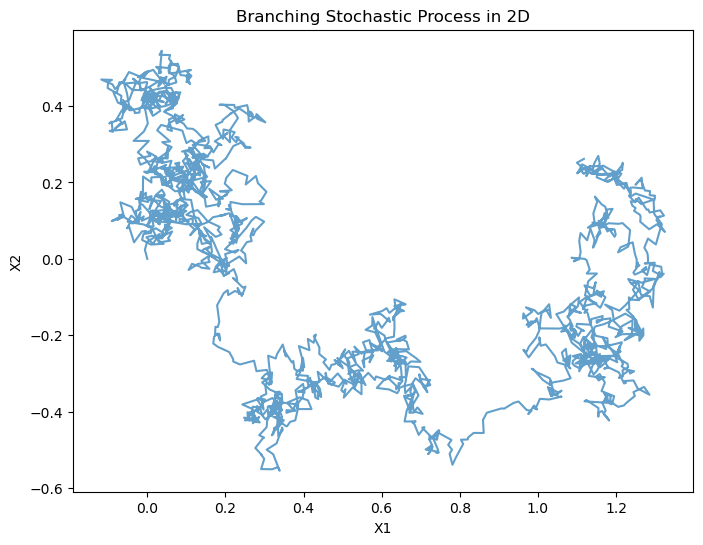

Branch times: []


In [7]:
import numpy as np
import matplotlib.pyplot as plt

class BranchingStochasticProcess:
    def __init__(self, A, G, X0, lambda_func, dt=0.01, T=1.0):
        self.A = np.array(A)  # d x d drift matrix
        self.G = np.array(G)  # d x d diffusion matrix
        self.X0 = np.array(X0)  # Initial position (d,)
        self.lambda_func = lambda_func  # Function defining branching rate
        self.dt = dt  # Time step
        self.T = T  # Total simulation time
        self.trajectories = []
        self.branch_times = []  # Store branching times
    
    def simulate(self):
        particles = [self.X0]
        self.trajectories = [[self.X0]]  # Store all trajectories
        
        t = 0
        ti = 0
        while t < self.T:
            new_particles = []
            new_trajectories = []
            for i, X in enumerate(particles):
                dW = np.random.randn(len(X)) * np.sqrt(self.dt)
                X_new = X + self.A @ X * self.dt + self.G @ dW
                
                # Branching condition (Poisson process)
                if np.random.rand() < self.lambda_func(X) * self.dt:
                    new_particles.append(X_new)  # Keep the original
                    new_particles.append(X_new)  # Create a new branch at the same position
                    self.branch_times.append(ti + 1)  # Store branching time
                    
                    # Duplicate trajectory for new branch
                    new_trajectories.append(self.trajectories[i] + [X_new])
                    new_trajectories.append(self.trajectories[i] + [X_new])
                else:
                    new_particles.append(X_new)
                    new_trajectories.append(self.trajectories[i] + [X_new])
                
            particles = new_particles
            self.trajectories = new_trajectories
            t += self.dt
            ti += 1
        
    def plot_trajectories(self):
        plt.figure(figsize=(8, 6))
        for traj in self.trajectories:
            traj = np.array(traj)
            plt.plot(traj[:, 0], traj[:, 1], alpha=0.7)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Branching Stochastic Process in 2D')
        plt.show()

# Example parameters
d = 2
A = np.array([[0.1, -0.2], [0.3, 0.1]])
G = np.array([[0.5, 0.0], [0.0, 0.5]])
X0 = np.array([0.0, 0.0])
lambda_func = lambda X: 0.5 * np.exp(-0.1 * np.linalg.norm(X))  # Decaying branching rate

process = BranchingStochasticProcess(A, G, X0, lambda_func, dt=0.001, T=2.0)
process.simulate()
process.plot_trajectories()
print("Branch times:", process.branch_times)


In [8]:
[len(t) for t in process.trajectories]

[2002]

In [9]:
np.array(process.trajectories[0]) == np.array(process.trajectories[1])

IndexError: list index out of range

In [13]:
A_rot = np.array([[0, 1],
              [-1, 0]])
A_contract = np.array([[-1, 0],
                      [0, -1]])

G = np.array([[1, 0],
              [0, 1]])

H = G @ G.T

def expAt(A, t):
    return linalg.expm(A*t)

def cov_integrand(A, H, t):
    return expAt(A, t) @ H @ expAt(A, t).T

def cov(A, H, t0, tf, n_integrate=10):
    ts = np.linspace(t0, tf, n_integrate)
    cov = np.zeros((2, 2))
    for i in range(n_integrate-1):
        cov += cov_integrand(A, H, tf - ts[i]) * (ts[i+1] - ts[i])
    return cov

def cov_approx(A, H, t0, tf):
    return H * (tf - t0)

def mean(A, x, t0, tf):
    return expAt(A, tf - t0)@x

def mean_approx(A, x, t0, tf):
    return x + A@x*(tf - t0)


def integrate_trajectory(x0, ts, A, H):
    A = np.array(A)
    H = np.array(H)
    dt = np.diff(ts)
    d = A.shape[1]
    xs = np.zeros((len(ts), d))
    xs[0] = x0

    for i in range(len(ts) - 1):
        xs[i + 1] = xs[i] + A@xs[i]*dt[i] + np.sqrt(dt[i])*np.random.multivariate_normal([0, 0], H)
    return xs

def many_trajectories(x0, A, H, N, ts):
    assert len(x0) == N
    xs = np.zeros((N, len(ts), A.shape[1]))
    for i in range(N):
        xs[i] = integrate_trajectory(x0[i], ts, A, H)
    return xs

def plot_time_matrix(A, rate=10):
    T = A.shape[2]
    for i in range(0, T, rate):
        plt.figure(figsize=(3, 3))
        # plt.subplot(1, T, i+1)
        plt.imshow(A[:, :, i])
        plt.colorbar()
        plt.show()


N_traj = 5
tn = 10000
t0 = 0
tf = 5
ts = np.linspace(0, tf, tn)
x0 = np.random.multivariate_normal([0, 0], 5*np.eye(2), N_traj)

A = A_rot # A_contract

# x = integrate_trajectory([0, 0], ts, A_rot, G)
xs = many_trajectories(x0, A, H, N_traj, ts)

print(xs.shape), print(ts.shape)

(5, 10000, 2)
(10000,)


(None, None)

In [14]:
def downsample(xs, ts, downsample_rate):
    return xs[:, ::downsample_rate, :], ts[::downsample_rate]

def plot_trajectory1d(xs, ts, idx, show=True, scatter=False, all=False, color="red", size=1):
    if not all:
        if not scatter:
            if color:
                plt.plot(ts, xs[idx, :, 0], label=f"x {idx}", color=color)
                plt.plot(ts, xs[idx, :, 1], label=f"y {idx}", color=color)
            else:
                plt.plot(ts, xs[idx, :, 0], label=f"x {idx}")
                plt.plot(ts, xs[idx, :, 1], label=f"y {idx}")
            plt.legend()
        else:
            for i in range(xs.shape[1]):
                plt.scatter(ts[i], xs[idx, i, 0], color=color, s=size)
                plt.scatter(ts[i], xs[idx, i, 1], color=color, s=size)
    if all:
        if scatter:
            for i in range(xs.shape[1]):
                for j in range(xs.shape[0]):
                    plt.scatter(ts[i], xs[j, i, 0], color=color, s=size)
                    plt.scatter(ts[i], xs[j, i, 1], color=color, s=size)
    if show:
        plt.show()


def plot_trajectory2d(xs, ts, idx, show=True):
    if idx == -1:
        for i in range(xs.shape[0]):
            plt.plot(xs[i, :, 0], xs[i, :, 1], label=f"trajectory {i}")
    else:
        plt.plot(xs[idx, :, 0], xs[idx, :, 1], label=f"trajectory {idx}")
        
    if show:
        plt.show()

# plot_trajectory2d(xs, ts, -1)
# plot_trajectory1d(xs, ts, 1, scatter=True)
# plt.plot(xs[:, :, 0].T, xs[:, :, 1].T, alpha=0.5);

Markovian approximation to full path measure:

$$
D(q^N || p^N) = \sum_{i=0}^{N-2} D(q_{i,i+1}|| p_{i, i+1}) + \sum_{i=1}^N D(q_i || p_i)
$$

We first consider solution $\pi_{i, i+1} = \argmin_{\pi \in \Pi(p_i, p_{i+1})}D(\pi || p^{A^{(k)}, H^{(k)}}_{i, i+1})$.

Note that

$$
\argmin_{\pi \in \Pi(p_i, p_{i+1})} D(\pi || (p_{A, H})_{i, i+1}) = \argmin_{\pi \in \Pi(p_i, p_{i+1})} D(\pi || K_{A, H}\,\hat{p}_i \otimes \hat{p}_{i+1})
$$

We can solve the latter problem by changing the cost $c$ in the Sinkhorn OT problem. 

Below we implement the algorithm to compute one Markov coupling. To solve for the full path measure we have to compose the couplings.

In [15]:
def kernel_approx_vec(x, y, t_curr, t_future, A, H):
    # kernel between (x, t_curr) and (y, t_future)
    m = x + x@A.T*(t_future - t_curr) # e^(Adt) x
    d = y[:, None] - m[None] # y - e^(Adt) x
    c = cov_approx(A, H, t_curr, t_future) # cov
    
    return np.exp(-np.einsum('ijk,kl,ijl->ji', d, np.linalg.inv(c), d)) # returns N x N kernel

def kernel_vec(x, y, t_curr, t_future, A, H):
    # matrix kernel between (x, t_curr) and (y, t_future)
    m = x@linalg.expm(A.T*(t_future - t_curr)) # e^(Adt) x
    d = y[:, None] - m[None] # y - e^(Adt) x
    c = cov(A, H, t_curr, t_future) # cov
    
    return np.exp(-np.einsum('ijk,kl,ijl->ji', d, np.linalg.inv(c), d)) # returns N x N kernel

def time_pairwise_kernel_rectangle(xs, ts, A, H, only_approx=False):
    K = []
    K_approx = []
    for i in range(len(ts) - 1):
        x = xs[:, i, :]
        y = xs[:, i + 1, :]
        t_curr = ts[i]
        t_future = ts[i + 1]
        if only_approx:
            K_approx_ = kernel_approx_vec(x, y, t_curr, t_future, A, H)
            K_ = K_approx_
        else:
            K_ = kernel_vec(x, y, t_curr, t_future, A, H)
            K_approx_ = kernel_approx_vec(x, y, t_curr, t_future, A, H)
        K.append(K_)
        K_approx.append(K_approx_)

    return K, K_approx

In [16]:
def kernel_func(y, m, c):
    return np.exp(-(y - m).T @ np.linalg.inv(c) @ (y - m))
    # return np.exp(np.dot(-(y - m), np.linalg.inv(c) @ (y - m)))

def kernel(x, y, t_curr, t_future, A, H):
    # kernel between (x, t_curr) and (y, t_future)
    kernel_mean = mean(A, x, t_curr, t_future)
    kernel_cov = cov(A, H, t_curr, t_future)
    # print(kernel_cov)
    kernel_mean_approx = mean_approx(A, x, t_curr, t_future)
    kernel_cov_approx = cov_approx(A, H, t_curr, t_future)
    K = kernel_func(y, kernel_mean, kernel_cov)
    K_approx = kernel_func(y, kernel_mean_approx, kernel_cov_approx)
    return K, K_approx

def pairwise_kernel(xs, ts, t_idx, A, H):
    N_traj = xs.shape[0]
    K = np.zeros((N_traj, N_traj))
    K_approx = np.zeros((N_traj, N_traj))
    for i in range(N_traj):
        for j in range(N_traj):
            t_curr = ts[t_idx]
            t_future = ts[t_idx + 1]
            x = xs[i, t_idx, :]
            y = xs[j, t_idx + 1, :]

            K[i,j], K_approx[i,j] = kernel(x, y, t_curr, t_future, A, H)

    return K, K_approx

def time_pairwise_kernel(xs, ts, A, H):
    N_traj = xs.shape[0]
    K = np.zeros((N_traj, N_traj, len(ts) - 1))
    K_approx = np.zeros((N_traj, N_traj, len(ts) - 1))

    for t_idx in range(len(ts) - 1):
        x = xs[:, t_idx, :]
        y = xs[:, t_idx + 1, :]
        t_curr = ts[t_idx]
        t_future = ts[t_idx + 1]
        K_ = kernel_vec(x, y, t_curr, t_future, A, H)
        K_approx_ = kernel_approx_vec(x, y, t_curr, t_future, A, H)
        K[:, :, t_idx] = K_
        K_approx[:, :, t_idx] = K_approx_

    return K, K_approx

def pairwise_optimal_transport(xs, t_curr, t_future):
    mu = np.ones(N_traj) / N_traj
    nu = np.ones(N_traj) / N_traj
    pi = OT_sinkhorn(mu, nu, K, maxiters = 100)
    plt.imshow(pi), plt.colorbar()
    
K, K_approx = pairwise_kernel(xs, ts, 0, A, H)

K_vec = kernel_vec(xs[:, 0, :], xs[:, 1, :], ts[0], ts[1], A, H)
K_vec_approx = kernel_approx_vec(xs[:, 0, :], xs[:, 1, :], ts[0], ts[1], A, H)

K_vec2 = kernel_vec(xs[:, 0, :], np.concatenate((xs[:, 1, :], xs[:, 1, :])), ts[0], ts[1], A, H)
print(K_vec2.shape)
# plt.imshow(K_vec), plt.show()
# plt.imshow(K), plt.show()
# print(K_vec)
# print(K)

print("vec:", np.linalg.norm(K - K_vec))
print("vec approx:", np.linalg.norm(K - K_vec_approx))
print("approx:", np.linalg.norm(K - K_approx))

(5, 10)
vec: 9.614813431917819e-17
vec approx: 2.4923807918857112e-05
approx: 2.4923807918822828e-05


(5, 10)


(<matplotlib.image.AxesImage at 0x1369bc550>,
 <matplotlib.colorbar.Colorbar at 0x136b56020>)

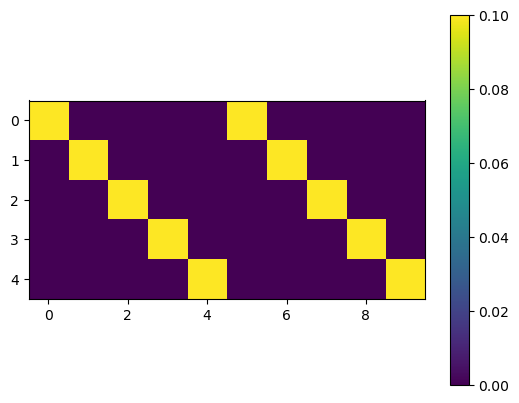

In [17]:
plt.imshow(K_vec2)
mu = np.ones(N_traj) / N_traj
nu = np.ones(2*N_traj) / (2*N_traj)
pi = OT_sinkhorn(mu, nu, K_vec2, maxiters=100)
print(K_vec2.shape)
plt.imshow(pi), plt.colorbar()

MLE Estimation 

$$
A = \frac{1}{\Delta t} \left(\sum_{i=0}^{N-2}\sum_{j=1}^M (\Delta X_i^j) X_i^{j^T} \right) \left(\sum_{i=0}^{N-1}\sum_{j=1}^M X_i^j X_i^{j^T} \right)^{-1}
$$

with $\Delta X_i = X_{i+1} - X_i$.

$$
H = \frac{1}{MT}\sum_{i=0}^{N-2}\sum_{j=1}^M (\Delta X_i^j - A X_i^{j} \Delta t)(\Delta X_i^j - A X_i^{j} \Delta t)^T 
$$


In [18]:
def A_mle(xs, ts):
    dt = np.diff(ts)[0]
    N_traj = xs.shape[0]
    d = xs.shape[2]
    N = len(ts)
    # dt_xs = np.einsum('ijk,j->ijk', xs, dt)
    X_X = np.einsum('ijk,ijl -> kl', xs*dt, xs)

    dxs = np.diff(xs, axis=1)
    DX_X = np.einsum('ijk,ijl -> kl', dxs, xs[:, :-1, :])

    A = DX_X @ np.linalg.inv(X_X)
    return A

def H_mle(xs, ts, A):
    dt = np.diff(ts)[0]
    N_traj = xs.shape[0]
    d = xs.shape[2]
    N = len(ts)
    T = ts[-1]
    dxs = np.diff(xs, axis=1)

    AX = np.einsum("lk,ijk -> ijl", A, xs[:, :-1, :])
    DX_AXdt = dxs - dt*AX

    H = (1 / (N_traj*T)) * np.einsum('ijk,ijl -> kl', DX_AXdt, DX_AXdt)
    return H
    

In [28]:
A, A_mle(xs, ts), H, H_mle(xs, ts, A)

(array([[ 0,  1],
        [-1,  0]]),
 array([[ 0.01179653,  1.02450003],
        [-0.98828814,  0.11665058]]),
 array([[1, 0],
        [0, 1]]),
 array([[ 1.00506747, -0.00215272],
        [-0.00215272,  0.99625701]]))

Solving the optimal transport problem associated with

$$
D(q_{i, i+1}||dK_{i, i+1}\hat{p}_i \otimes \hat{p}_{i+1})
$$

In [886]:
def OT_time_kernel_rectangle(xs, ts, A, H, maxiters = 1000):
    # K is python array
    Pi = []
    K, K_approx = time_pairwise_kernel_rectangle(xs, ts, A, H, only_approx=False)
    for t_idx in range(len(ts) - 1):
        N_curr = K[t_idx].shape[0]
        N_future = K[t_idx].shape[1]
    
        mu = np.ones(N_curr) / N_curr
        nu = np.ones(N_future) / N_future
        pi = OT_sinkhorn(mu, nu, K[t_idx], maxiters=maxiters)
        Pi.append(pi)
    return Pi, K, K_approx

In [910]:
def OT_time_kernel(xs, ts, A, H, maxiters = 1000):
    K, K_approx = time_pairwise_kernel(xs, ts, A, H)
    Pi = np.zeros_like(K)
    for t_idx in range(len(ts) - 1):
        mu = np.ones(N_traj) / N_traj
        nu = np.ones(N_traj) / N_traj
        pi = OT_sinkhorn(mu, nu, K[:, :, t_idx], maxiters=maxiters)
        Pi[:, :, t_idx] = pi
    return Pi, K, K_approx

(5, 5, 19)
(5, 5) 19


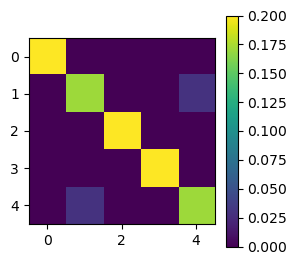

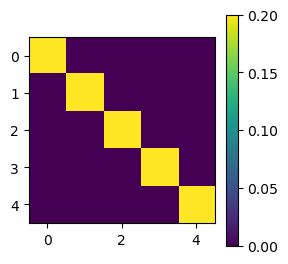

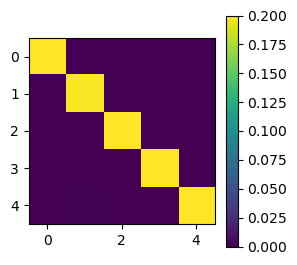

In [922]:
downsample_rate = 500
xs_downsampled, ts_downsampled = downsample(xs, ts, downsample_rate)
# print(xs_downsampled.shape, ts_downsampled.shape)
Pi, K, K_approx = OT_time_kernel(xs_downsampled, ts_downsampled, A, H, maxiters = 1000)

Pi_rect, K_rect, K_approx_rect = OT_time_kernel_rectangle(xs_downsampled, ts_downsampled, A, H, maxiters = 1000)

Pi_rect = np.array(Pi_rect)

print(Pi.shape)
print(Pi_rect[0].shape, len(Pi_rect))
plot_time_matrix(Pi, Pi.shape[2] // 2)

Instead of calculating the full path measure $q^N$, we generate trajectories from the joint couplings which we inferred using our estimates of $A, H$.

Transport map $\pi$ from $\hat{p}_i$ to $\hat{p}_{i+1}$ in discrete form is given by, $\sum_j \pi_{lj} = (\hat{p}_{i + 1})_l$, $\sum_l \pi_{lj} = (\hat{p}_i)_l$. So $p_i$ is distributed along the columns of $\pi$ and $p_{i+1}$ along the rows. Therefore, if I uniformly choose a particule from $p_i$ and obtain $(p_i)_l$ then the conditional distribution is $p_{i+1 | i}(x_l | x_j) = \frac{\pi_{lj}}{\sum_k \pi_{kj}} = \frac{\pi_{lj}}{(p_i)_l}$

In [ ]:
def normalize_column(column):
    return column / np.sum(column)

def sample_trajectory_idxs(Pi, N_sample):
    N_traj = Pi.shape[0] # assuming constant number of trajectories
    N = Pi.shape[2] + 1
    idxs_sampled = np.zeros((N_sample, N), dtype=int)
    
    for i in range(N_sample):
        sample_idx = np.random.choice(N_traj) # uniformly choose a random trajectory
        idxs_sampled[i, 0] = sample_idx
        
        for t_idx in range(1, N):
            pi_next_given_curr = normalize_column(Pi[:, sample_idx, t_idx - 1]) # conditional p_{i+1 | i}
            sample_idx = np.random.choice(N_traj, p=pi_next_given_curr)
            idxs_sampled[i, t_idx] = sample_idx
    return idxs_sampled

def sample_trajectory_idxs_rectangle(Pi, N_sample):
    N = len(Pi) + 1
    idxs_sampled = np.zeros((N_sample, N), dtype=int)
    
    for i in range(N_sample):
        N_traj = Pi[0].shape[0] # assuming constant number of trajectories
        sample_idx = np.random.choice(N_traj) # uniformly choose a random trajectory
        idxs_sampled[i, 0] = sample_idx
        
        for t_idx in range(1, N):
            N_traj = Pi[t_idx - 1].shape[0]
            
            pi_next_given_curr = normalize_column(Pi[t_idx - 1][:, sample_idx]) # conditional p_{i+1 | i}
            sample_idx = np.random.choice(N_traj, p=pi_next_given_curr)
            idxs_sampled[i, t_idx] = sample_idx
            
    return idxs_sampled

def index_trajectory(xs, idxs_sampled):
    assert idxs_sampled.shape[1] == xs.shape[1] # same number of time steps
    N = idxs_sampled.shape[1]
    N_sample = idxs_sampled.shape[0]
    d = xs.shape[2]
    xs_sampled = np.zeros((N_sample, N, d))
    for i in range(N):
        xs_sampled[:, i, :] = xs[idxs_sampled[:, i], i, :]
    return xs_sampled

def sample_trajectory_xs(Pi, xs, N_sample):
    idxs_sampled = sample_trajectory_idxs(Pi, N_sample)
    return index_trajectory(xs, idxs_sampled), idxs_sampled

def sample_trajectory_xs_rectangle(Pi, xs, N_sample):
    idxs_sampled = sample_trajectory_idxs_rectangle(Pi, N_sample)
    return index_trajectory(xs, idxs_sampled), idxs_sampled

`xs_downsampled` is `N_traj x N_downsample x d` with `N` the number of time steps

`idxs_sampled` is `N_sample x N_downsample`

I want `N_sample x N x d`

(10, 20, 2)
[4 1]


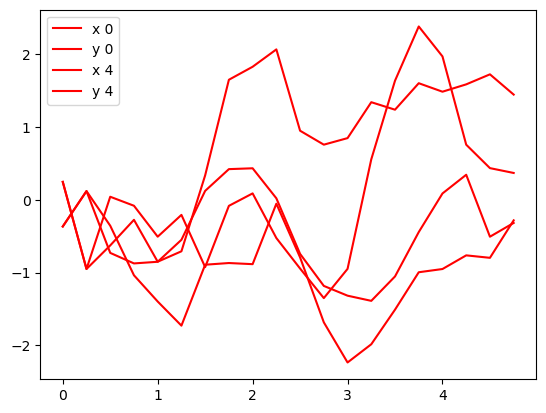

In [ ]:
# idxs_sampled = sample_trajectory_idxs(Pi, N_sample=100)
# xs_sampled = index_trajectory(xs_downsampled, idxs_sampled)
xs_sampled, idxs_sampled = sample_trajectory_xs(Pi, xs_downsampled, N_sample=1)
xs_sampled, idxs_sampled = sample_trajectory_xs_rectangle(Pi_rect, xs_downsampled, N_sample=10)

print(xs_sampled.shape)

print(idxs_sampled[0][::10])
plot_trajectory1d(xs_sampled, ts_downsampled, 0, show=False)
plot_trajectory1d(xs_downsampled, ts_downsampled, idxs_sampled[0, 0], show=False)
# plot_trajectory2d(xs_sampled, ts_downsampled, 0)


Now we have a way of sampling trajectories from the coupling matrices associated with the marginals. Now we perform the algorithm, first guess $A, H$

1. Perform weighted OT with $A, H$
2. Sample trajectories using the coupling
3. Estimate $A, H$ using MLE
4. Go back to step 1 with new $A, H$.

In [944]:
xs_data, ts_data = downsample(xs, ts, 500)
print(xs_data.shape, ts_data.shape)

def appex(xs_data, ts_data, A, H, N_sample, tol = 1e-5, maxiters = 100, print_out = 100):
    d = xs_data.shape[2]
    As = [np.zeros((d, d)), A] # collection of A matrices
    Hs = [np.zeros((d, d)), H] #
    Pis = []
    i = 0
    while i < maxiters:
        running_tol = np.linalg.norm(As[-1] - As[-2]) / np.linalg.norm(As[-2])
        if running_tol < tol:
            print(f"tolerance reached at iteration {i}")
            break
        if i % print_out == 0:
            print(f"iteration {i}, running tolerance {running_tol}")
        Pi, K, K_approx = OT_time_kernel(xs_data, ts_data, As[-1], Hs[-1], maxiters = 100)
        xs_sampled, idxs_sampled = sample_trajectory_xs(Pi, xs_data, N_sample = N_sample)

        A_mle_ = A_mle(xs_sampled, ts_data)
        H_mle_ = H_mle(xs_sampled, ts_data, A_mle_)
        As.append(A_mle_)
        Hs.append(H_mle_)
        Pis.append(Pi)
        i += 1
    return As, Hs, Pis

A_guess = A
H_guess = H

As, Hs, Pis = appex(xs_data, ts_data, A_guess, H_guess, N_sample=1, tol=1e-1, maxiters=10000, print_out=1000)

(5, 20, 2) (20,)
iteration 0, running tolerance inf
tolerance reached at iteration 8


/var/folders/zr/tnch39_n5hx8s_zsx1gqggch0000gn/T/ipykernel_17117/3350026572.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  running_tol = np.linalg.norm(As[-1] - As[-2]) / np.linalg.norm(As[-2])


In [1]:
xs_data, ts_data = downsample(xs, ts, 500)
print(xs_data.shape, ts_data.shape)

def appex_rectangle(xs_data, ts_data, A, H, N_sample, tol = 1e-5, maxiters = 100, print_out = 100):
    d = xs_data.shape[2]
    As = [np.zeros((d, d)), A] # collection of A matrices
    Hs = [np.zeros((d, d)), H] #
    Pis = []
    i = 0
    while i < maxiters:
        running_tol = np.linalg.norm(As[-1] - As[-2]) / np.linalg.norm(As[-2])
        if running_tol < tol:
            print(f"tolerance reached at iteration {i}")
            break
        if i % print_out == 0:
            print(f"iteration {i}, running tolerance {running_tol}")
        # Pi, K, K_approx = OT_time_kernel(xs_data, ts_data, As[-1], Hs[-1], maxiters = 100)
        Pi, K, K_approx = OT_time_kernel_rectangle(xs_data, ts_data, As[-1], Hs[-1], maxiters = 100)
        # xs_sampled, idxs_sampled = sample_trajectory_xs(Pi, xs_data, N_sample = N_sample)
        xs_sampled, idxs_sampled = sample_trajectory_xs_rectangle(Pi, xs_data, N_sample = N_sample)

        A_mle_ = A_mle(xs_sampled, ts_data)
        H_mle_ = H_mle(xs_sampled, ts_data, A_mle_)
        As.append(A_mle_)
        Hs.append(H_mle_)
        Pis.append(Pi)
        i += 1
    return As, Hs, Pis

A_guess = A
H_guess = H

As, Hs, Pis = appex_rectangle(xs_data, ts_data, A_guess, H_guess, N_sample=1, tol=1e-1, maxiters=10000, print_out=1000)

NameError: name 'downsample' is not defined

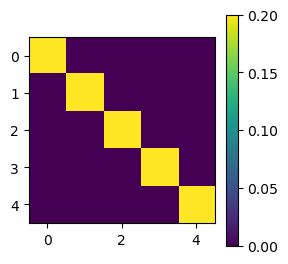

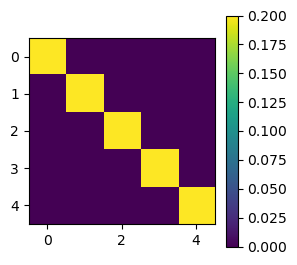

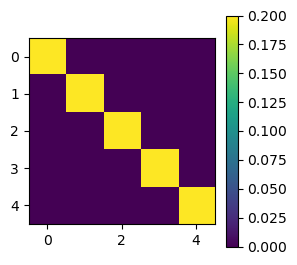

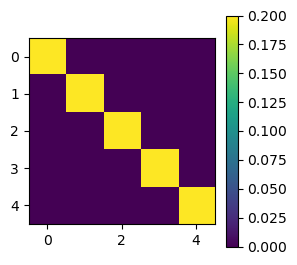

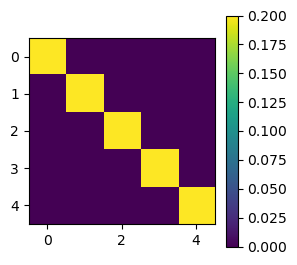

In [946]:
plot_time_matrix(Pi_est, 1000)

A: [[ 0  1]
 [-1  0]] 
 A_est: [[ 0.0044805   1.00328482]
 [-0.82688873 -0.33037161]]
H: [[1 0]
 [0 1]] 
 H_est [[0.77870952 0.22902265]
 [0.22902265 0.70125638]]
N_traj 5


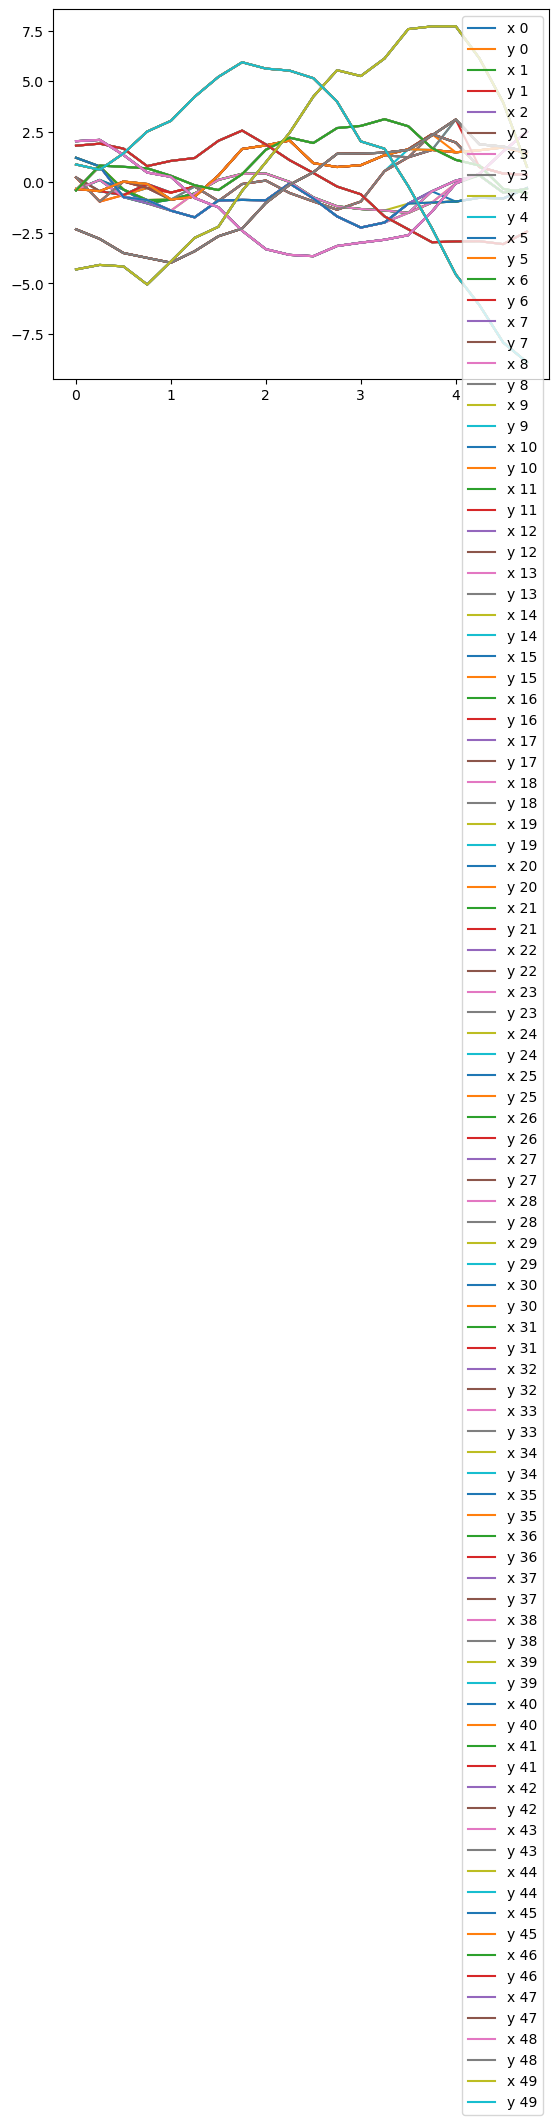

In [950]:
N_sample = 50
A_est = As[-1]
H_est = Hs[-1]
Pi_est = Pis[-1]
# xs_sampled, idxs_sampled = sample_trajectory_xs(Pi_est, xs_data, N_sample=N_sample)
xs_sampled, idxs_sampled = sample_trajectory_xs_rect(Pi_est, xs_data, N_sample=N_sample)

print("A:", A, "\n", "A_est:", As[-1])
print("H:", H, "\n", "H_est", Hs[-1])
print("N_traj", N_traj)
# plot_trajectory1d(xs_data, ts_data, 0, show=False)
[plot_trajectory1d(xs_sampled, ts_data, i, show=False, scatter=False, color="") for i in range(N_sample)];
# [plot_trajectory1d(xs_data, ts_data, i, show=False, scatter=False) for i in range(xs_data.shape[0])]
# plot_trajectory1d(xs_data, ts_data, 0, show=False, scatter=True, all=True, size=1)

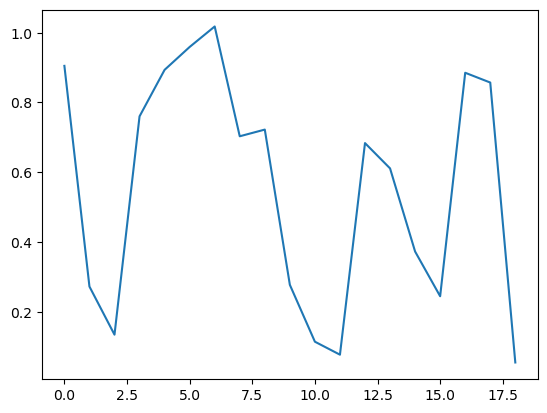

In [794]:
from closest_permutation import *

# fig, axs = plt.subplots(1, 2)
# idx = 10
# axs[0].imshow(Pi_est[:, :, idx]), axs[1].imshow(P), plt.show()

dist_from_permutation = distance_from_permutation(Pi)
plt.plot(dist_from_permutation)

# visualize_two_matrices(Pi[:, :, 0], P)

With $\pi_{1,2}$ coupling between $\mu_1$ and $\mu_2$ and $\pi_{2,3}$ coupling between $\mu_2$ and $\mu_3$.

$$
\pi_{1,2} \circ \pi_{2,3}(dx_1, dx_2, dx_3) = \pi_{1,2}(dx_1 | x_2)\mu_2(dx_2)\pi_{2,3}(dx_3 | x_2).
$$

where $\pi_{1,2}(dx_1 | x_2)$ is the disintegration with respect to $\mu_2$. In otherwords,

$$
\pi_{1,2}(dx_1 | x_2) \mu_2(dx_2) = \pi_{1,2}(dx_1, dx_2)
$$

If we are given the couplings between $\mu_1, \mu_2$, and $\mu_3$, we want $\pi(x_1, x_2, x_3)$ with marginals $\mu_i$. Therefore,

$$
\pi_{1,2}(dx_1 | x_2) = \frac{\pi_{1,2}(dx_1, x_2)}{\mu_2(x_2)}
$$

or also,

$$
\mu_2(x_2) = \int \pi_{1, 2}(x_1, x_2)dx_1 = \int \pi_{2,3}(x_2, x_3)dx_3
$$

$$
\pi(x_1, x_2, x_3) = \pi(x_3 | x_2, x_1)\mu(x_1, x_2) = \pi(x_3 | x_2)\mu(x_2 | x_1) \mu(x_1)
$$

$$
\pi_{1,2}(x_1 | x_2)\mu_2(x_2)\pi_{2,3}(x_3 | x_2)dx_1 dx_2 dx_3 = \pi_{1,2}(dx_1 | x_2)
$$

$$
q^N = \pi_{}
$$

In [185]:
np.sum(Pi[:, :, 0], axis=1)

array([0.5, 0.5])